# General Summary
The analyzed dataset contains records of domestic coffee consumption from 1990 to 2019, broken down by country and coffee type (Arabica, Robusta, Arabica/Robusta, and Robusta/Arabica). The dataset also includes the continent information for each country to facilitate aggregated analyses by region.

In [18]:
# Coffee Consumption Analysis

# Required imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from IPython.display import display
import warnings
import logging
warnings.filterwarnings("ignore")
logging.getLogger('prophet').setLevel(logging.ERROR)
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

In [19]:
# --------------------------------------
# Load and Explore Data
# --------------------------------------
url = "https://raw.githubusercontent.com/Jhonarsa/Coffee-data/refs/heads/main/02%20Data/2.%20Cleaned%20data/Coffee%20data%20cleaned.csv"
df = pd.read_csv(url)

# Modelo de clasificación

In [20]:
######### Classify countries according to their consumption ##########

ultimo_anio = df["Year"].max()

df_cluster = (
    df[df["Year"] == ultimo_anio]
    .groupby("Country", as_index=False)["Consumption"]
    .sum()
    .rename(columns={"Consumption": "Consumo_Anual"})
)

scaler = StandardScaler()
df_cluster["Consumo_Escalado"] = scaler.fit_transform(df_cluster[["Consumo_Anual"]])

kmeans = KMeans(n_clusters=3, random_state=42)
df_cluster["Cluster"] = kmeans.fit_predict(df_cluster[["Consumo_Escalado"]])

orden = df_cluster.groupby("Cluster")["Consumo_Anual"].mean().sort_values()
etiquetas = {orden.index[0]: "Low", orden.index[1]: "Medium", orden.index[2]: "High"}
df_cluster["Nivel_Consumo"] = df_cluster["Cluster"].map(etiquetas)

df = df.merge(df_cluster[["Country", "Nivel_Consumo"]], on="Country", how="left")

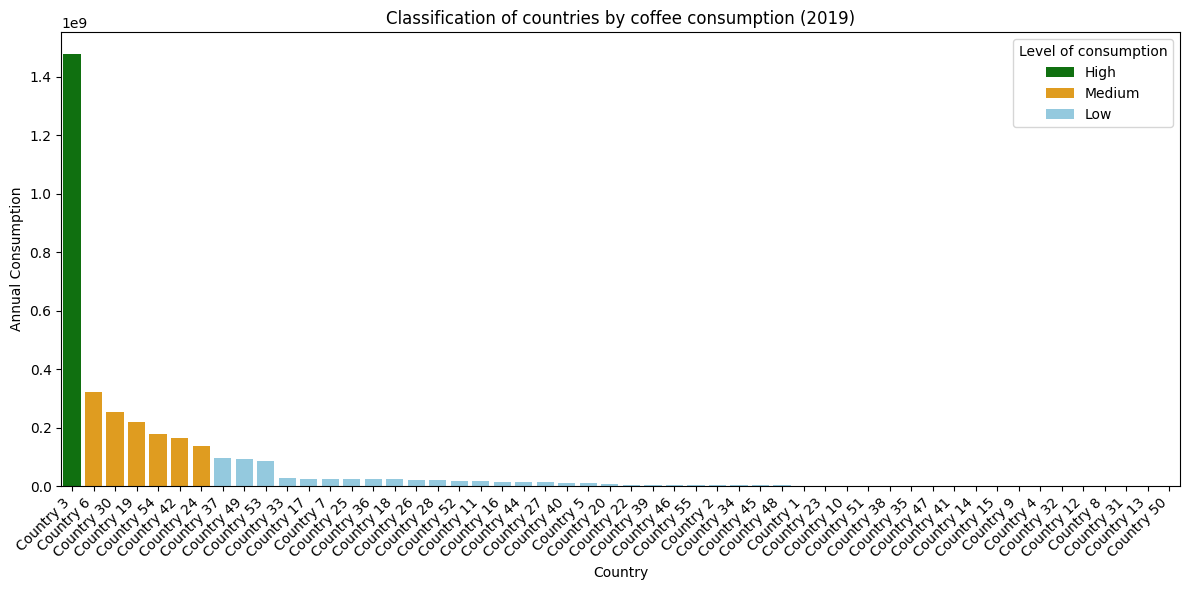

In [21]:
df_plot = df_cluster.sort_values("Consumo_Anual", ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_plot,
    x="Country",
    y="Consumo_Anual",
    hue="Nivel_Consumo",
    palette={"Low": "skyblue", "Medium": "orange", "High": "green"}
)

plt.title(f"Classification of countries by coffee consumption ({ultimo_anio})")
plt.xlabel("Country")
plt.ylabel("Annual Consumption")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Level of consumption")
plt.tight_layout()
plt.show()

Clustering of Countries:
- The K-Means algorithm was applied to segment countries based on their consumption levels recorded in the most recent available year (2019/2020).
- This classification enabled the identification of three strategic groups:
  -  High-consumption countries: Potential mature or priority markets.
  -  Medium-consumption countries: Expanding economies with stable growth.
  -  Low-consumption countries: Possible opportunities for development or future investment.


In [23]:
df_cluster.to_csv("segmented_countries.csv", index=False)